## Student Information
Name: Kezia Flaviana Irene Tamus

Student ID: 110065428

GitHub ID: keziatamus

Kaggle name: keziaflaviana

Kaggle private scoreboard snapshot: 

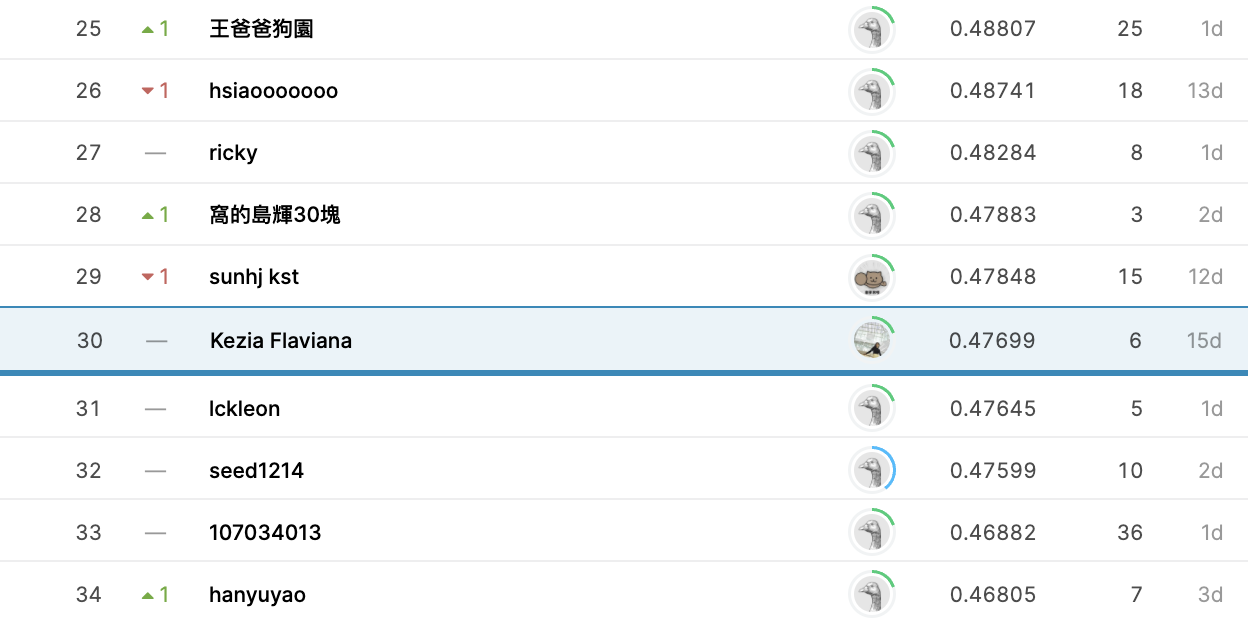

---

## Instructions
First: This part is worth 30% of your grade. Do the take home exercises in the DM2021-Lab2-master Repo. You may need to copy some cells from the Lab notebook to this notebook.

Second: This part is worth 30% of your grade. Participate in the in-class Kaggle Competition regarding Emotion Recognition on Twitter. The scoring will be given according to your place in the Private Leaderboard ranking:
* Bottom 40%: Get 20% of the 30% available for this section.
* Top 41% - 100%: Get (60-x)/6 + 20 points, where x is your ranking in the leaderboard (ie. If you rank 3rd your score will be (60-3)/6 + 20 = 29.5% out of 30%)
* Submit your last submission BEFORE the deadline (Dec. 24th 11:59 pm, Friday). Make sure to take a screenshot of your position at the end of the competition and store it as '''pic0.png''' under the img folder of this repository and rerun the cell Student Information.

Third: This part is worth 30% of your grade. A report of your work developping the model for the competition (You can use code and comment it). This report should include what your preprocessing steps, the feature engineering steps and an explanation of your model. You can also mention different things you tried and insights you gained.

Fourth: This part is worth 10% of your grade. It's hard for us to follow if your code is messy :'(, so please tidy up your notebook and add minimal comments where needed.
Upload your files to your repository then submit the link to it on the corresponding e-learn assignment.

Make sure to commit and save your changes to your repository BEFORE the deadline (Dec. 29th 11:59 pm, Wednesday).

---

# Part 1
## 1. Data Preparation
Before beggining the lab, please make sure to download the Google News Dataset and place it in a folder named "GoogleNews" in the same directory as this file.

### 1.1 Load data
We start by loading the csv files into a single pandas dataframe for training and one for testing.

In [1]:
import pandas as pd

### training data
anger_train = pd.read_csv("../input/dm2021-lab2-master/data/semeval/train/anger-ratings-0to1.train.txt",
                         sep="\t", header=None,names=["id", "text", "emotion", "intensity"])
sadness_train = pd.read_csv("../input/dm2021-lab2-master/data/semeval/train/fear-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
fear_train = pd.read_csv("../input/dm2021-lab2-master/data/semeval/train/joy-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
joy_train = pd.read_csv("../input/dm2021-lab2-master/data/semeval/train/sadness-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])

In [2]:
# combine 4 sub-dataset
train_df = pd.concat([anger_train, fear_train, joy_train, sadness_train], ignore_index=True)

In [3]:
### testing data
anger_test = pd.read_csv("../input/dm2021-lab2-master/data/semeval/dev/anger-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
sadness_test = pd.read_csv("../input/dm2021-lab2-master/data/semeval/dev/fear-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
fear_test = pd.read_csv("../input/dm2021-lab2-master/data/semeval/dev/joy-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
joy_test = pd.read_csv("../input/dm2021-lab2-master/data/semeval/dev/sadness-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])

# combine 4 sub-dataset
test_df = pd.concat([anger_test, fear_test, joy_test, sadness_test], ignore_index=True)
train_df.head()

In [4]:
# shuffle dataset
train_df = train_df.sample(frac=1)
test_df = test_df.sample(frac=1)

In [5]:
print("Shape of Training df: ", train_df.shape)
print("Shape of Testing df: ", test_df.shape)

### Exercise 1
#### Plot word frequency for Top 30 words in both train and test dataset. (Hint: refer to DM lab 1)

In [6]:
df_text_train = train_df['text'].values
df_text_test = test_df['text'].values

In [7]:
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer

def get_top_words(corpus, n=None):
    count_vect = CountVectorizer(stop_words="english")
    count_fit = count_vect.fit_transform(corpus)
    tf_text = np.asarray(count_fit.sum(axis=0))[0]
    df_counts = pd.DataFrame({'Terms': count_vect.get_feature_names(), 'Freq': tf_text})
    df_counts.sort_values(by=['Freq'], inplace=True, ascending=False)
    return df_counts[:n]

In [8]:
# top 30 words of train data
train_top_words = get_top_words(df_text_train, n=30)
train_top_df = pd.DataFrame (train_top_words)
train_top_df.columns=["Terms","Freq"]

# barplot of most freq words
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(x="Terms", y="Freq", data=train_top_df)
g.set_xticklabels(g.get_xticklabels(), rotation=30)
g.set_title("Top 30 words in train dataset")

In [9]:
# top 30 words of test data
test_top_words = get_top_words(df_text_test, n=30)
test_top_df = pd.DataFrame (test_top_words)
test_top_df.columns=["Terms","Freq"]

# barplot of most freq words
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(x="Terms", y="Freq", data=test_top_df)
g.set_xticklabels(g.get_xticklabels(), rotation=30)
g.set_title("Top 30 words in test dataset")

---

## 2. Feature Engineering
### 2.1 Using Bag-of-Words

In [10]:
import nltk
from sklearn.feature_extraction.text import CountVectorizer

# build analyzers (bag-of-words)
BOW_500 = CountVectorizer(max_features=500, tokenizer=nltk.word_tokenize) 

# apply analyzer to training data
BOW_500.fit(train_df['text'])

train_data_BOW_features_500 = BOW_500.transform(train_df['text'])

# check dimension
train_data_BOW_features_500.shape

In [11]:
# observe some feature names
feature_names_500 = BOW_500.get_feature_names()
feature_names_500[100:110]

### Exercise 2
#### Generate an embedding using the TF-IDF vectorizer instead of the BOW one with 1000 features and show the feature names for features [100:110].

In [12]:
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer


tfidf_vect = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word', 
                        stop_words= 'english',ngram_range=(1,1))
tfidf_train = tfidf_vect.fit_transform(train_df['text'])

# check dimension
print(tfidf_train.shape)

# check feature name
print(tfidf_vect.get_feature_names()[100:110])

In [13]:
# observe some feature names
feature_names_1000 = tfidf_vect.get_feature_names()
feature_names_1000[100:110]

---

## 3. Model

In [14]:
# for a classification problem, you need to provide both training & testing data
X_train = BOW_500.transform(train_df['text'])
y_train = train_df['emotion']

X_test = BOW_500.transform(test_df['text'])
y_test = test_df['emotion']

# take a look at data dimension is a good habbit  :)
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

In [15]:
train_df[:10]

In [16]:
test_df[:10]

### 3.1 Decision Trees

In [17]:
from sklearn.tree import DecisionTreeClassifier

# build DecisionTree model
DT_model = DecisionTreeClassifier(random_state=0)

# training!
DT_model = DT_model.fit(X_train, y_train)

# predict!
y_train_pred = DT_model.predict(X_train)
y_test_pred = DT_model.predict(X_test)

# so we get the pred result
y_test_pred[:10]

---

## 4. Results Evaluation

In [18]:
# accuracy
from sklearn.metrics import accuracy_score

acc_train = accuracy_score(y_true=y_train, y_pred=y_train_pred)
acc_test = accuracy_score(y_true=y_test, y_pred=y_test_pred)

print('training accuracy: {}'.format(round(acc_train, 2)))
print('testing accuracy: {}'.format(round(acc_test, 2)))

In [19]:
# precision, recall, f1-score,
from sklearn.metrics import classification_report

print(classification_report(y_true=y_test, y_pred=y_test_pred))

In [20]:
# check by confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true=y_test, y_pred=y_test_pred) 
print(cm)

In [21]:
# function for visualizing confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix',
                          cmap=sns.cubehelix_palette(as_cmap=True)):
    """
    This function is modified from: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    classes.sort()
    tick_marks = np.arange(len(classes))    
    
    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels = classes,
           yticklabels = classes,
           title = title,
           xlabel = 'True label',
           ylabel = 'Predicted label')

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    ylim_top = len(classes) - 0.5
    plt.ylim([ylim_top, -.5])
    plt.tight_layout()
    plt.show()

In [22]:
# plot your confusion matrix
my_tags = ['anger', 'fear', 'joy', 'sadness']
plot_confusion_matrix(cm, classes=my_tags, title='Confusion matrix')

### Exercise 3
#### Can you interpret the results above? What do they mean?
**Confusion matrix can be used to measure the performance of a machine learning algorithm.** 

We can see how there are four rows that represent the true label, and four columns that represent the instances of a predicted class. 

The number or the shade shows the distribution of prediction. The darker the color, the larger the value. **The diagonal elements are the True Positive (TP), where the predicted class is the same as the actual class.** In details, the total numbers of TP of anger, fear, joy, and sadness are 57, 75, 53, and 44 repsectively. For example, on the top left corner, the machine learning predicts that the tag is about 'anger' (first row: anger - prediction) and it is indeed about anger (fourth column: anger - true label). In other words, the machine learning accurately predicts the right tag for 'anger' 57 times.

There is another term called False Negative (FN), which is the sum of values in the corresponding column. From the example above, it is 11 + 6 + 7 = 24. Also, a term called False Positive (FP), which is the sum of values in the corresponding row. Again, we can calculate the FP from the example above, 11 + 7 + 9 = 27.

### Exercise 4

#### Build a model using a Naive Bayes model and train it. What are the testing results?

In [23]:
from sklearn.naive_bayes import MultinomialNB

# build MultinomialNB model
NB_model = MultinomialNB()

# training!
NB_model = NB_model.fit(X_train, y_train)

# predict!
y_train_pred = NB_model.predict(X_train)
y_test_pred = NB_model.predict(X_test)

# so we get the pred result
y_test_pred[:10]

In [24]:
# accuracy

acc_train = accuracy_score(y_true=y_train, y_pred=y_train_pred)
acc_test = accuracy_score(y_true=y_test, y_pred=y_test_pred)

print('training accuracy: {}'.format(round(acc_train, 2)))
print('testing accuracy: {}'.format(round(acc_test, 2)))

In [25]:
# precision, recall, f1-score,
from sklearn.metrics import classification_report

print(classification_report(y_true=y_test, y_pred=y_test_pred))

In [26]:
# check by confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true=y_test, y_pred=y_test_pred) 
print(cm)

In [27]:
# plot your confusion matrix
my_tags = ['anger', 'fear', 'joy', 'sadness']
plot_confusion_matrix(cm, classes=my_tags, title='Confusion matrix')

### Exercise 5
#### How do the results from the Naive Bayes model and the Decision Tree model compare? How do you interpret these differences? Use the theoretical background covered in class to try and explain these differences.

**Decision Tree model**: training accuracy: 0.99, testing accuracy: 0.66

**Naive Bayes model**: training accuracy: 0.79, testing accuracy: 0.71

Based on the accuracy of these two models, we can see how the training accuracy for decision tree is very high. However, when we check the testing accuracy, the result descreases significantly from 0.99 to 0.66 only. The reason for this might be caused by the fact that decision tree tends to overfit and it can lead to wrong predictions. We can conclude that decision tree performs well on the trained data but starts making a lot of mistakes when it comes to predicting unseen data.

On the other hand, when we apply multinomial naive bayes model, the training and testing accuracy are not far from each other. They are both above 0.70, so we can assume that there is no overfitting issue. However, the accuracy results aren't exceedingly high because naive bayes classifier assumes that the features are unrelated to each other, so it is hard to learn the relationship between features.

---

## 5. Other things you can try
Thus, there are several things you can try that will affect your results. In order to yield better results, you can experiment by:

* Trying different features (Feature engineering)
    -Eg. Word2Vec,PCA,LDA,FastText, Clustering......
* Trying different models
* Analyzing your results and interpret them to improve your feature engineering/model building process
* Iterate through the steps above until finding a satisfying result

Remember that you should also consider the task at hand and the model you'll feed the data to.

---

## 6. Deep Learning
### 6.1 Prepare Data (x, y)

In [28]:
import keras

# standardize name (X, y) 
X_train = BOW_500.transform(train_df['text'])
y_train = train_df['emotion']

X_test = BOW_500.transform(test_df['text'])
y_test = test_df['emotion']

## check dimension is a good habbit 
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

### 6.2 Deal with categorical label (y)

In [29]:
# deal with label (string -> one-hot)

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(y_train)
print('check label: ', label_encoder.classes_)
print('\n## Before convert')
print('y_train[0:4]:\n', y_train[0:4])
print('\ny_train.shape: ', y_train.shape)
print('y_test.shape: ', y_test.shape)

def label_encode(le, labels):
    enc = le.transform(labels)
    return keras.utils.np_utils.to_categorical(enc)

def label_decode(le, one_hot_label):
    dec = np.argmax(one_hot_label, axis=1)
    return le.inverse_transform(dec)

y_train = label_encode(label_encoder, y_train)
y_test = label_encode(label_encoder, y_test)

print('\n\n## After convert')
print('y_train[0:4]:\n', y_train[0:4])
print('\ny_train.shape: ', y_train.shape)
print('y_test.shape: ', y_test.shape)

### 6.3 Build model

In [30]:
# I/O check
input_shape = X_train.shape[1]
print('input_shape: ', input_shape)

output_shape = len(label_encoder.classes_)
print('output_shape: ', output_shape)

In [31]:
from keras.models import Model
from keras.layers import Input, Dense
from keras.layers import ReLU, Softmax

# input layer
model_input = Input(shape=(input_shape, ))  # 500
X = model_input

# 1st hidden layer
X_W1 = Dense(units=64)(X)  # 64
H1 = ReLU()(X_W1)

# 2nd hidden layer
H1_W2 = Dense(units=64)(H1)  # 64
H2 = ReLU()(H1_W2)

# output layer
H2_W3 = Dense(units=output_shape)(H2)  # 4
H3 = Softmax()(H2_W3)

model_output = H3

# create model
model = Model(inputs=[model_input], outputs=[model_output])

# loss function & optimizer
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# show model construction
model.summary()

### 6.4 Train

In [32]:
from keras.callbacks import CSVLogger

csv_logger = CSVLogger('/kaggle/working/training_log.csv')

# training setting
epochs = 25
batch_size = 32

# training!
history = model.fit(X_train, y_train, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    callbacks=[csv_logger],
                    validation_data = (X_test, y_test))
print('training finish')

### 6.5 Predict on testing data

In [33]:
## predict
pred_result = model.predict(X_test, batch_size=128)
pred_result[:5]

In [34]:
pred_result = label_decode(label_encoder, pred_result)
pred_result[:5]

In [35]:
from sklearn.metrics import accuracy_score

print('testing accuracy: {}'.format(round(accuracy_score(label_decode(label_encoder, y_test), pred_result), 2)))

In [36]:
# let's take a look at the training log
training_log = pd.DataFrame()
training_log = pd.read_csv("/kaggle/working/training_log.csv")
training_log

### Exercise 6
#### Plot the Training and Validation Accuracy and Loss (different plots)

In [37]:
plt.figure(figsize=(16,9))

plt.title('Training Accuracy per epoch')
plt.plot(training_log['epoch'], training_log['accuracy'], color='blue')
plt.plot(training_log['epoch'], training_log['val_accuracy'], color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train accuracy','val accuracy'], loc='upper right')
plt.show()


In [38]:
plt.figure(figsize=(16,9))

plt.title('Training Accuracy per epoch')
plt.plot(training_log['epoch'], training_log['loss'], color='blue')
plt.plot(training_log['epoch'], training_log['val_loss'], color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train loss','val loss'], loc='upper right')
plt.show()


From the first graph, we can see that the models start off with the same accuracy. However, the gap is starting to become bigger after the 3rd epochs. In the end, the maximum accuracy that can be obtained by the training accuracy and val accuracy are around 0.65 and 0.98 respectively. There is an indication that **the model is learning the training data but not the testing data.**

The result of the above graph is related to the concept of **overfitting**. The reason for this is because the training accuracy is increasing and the training loss is decreasing (the accuracy is nearly 1 and the loss is nearly 0), meaning that the model is learning the training data really well. However, when we feed the model the testing data, it somehow fails to to generalize the knowledge of this new data. We can see how the val accuracy is going down and val loss is going up (more inaccurate). We can conclude from these graphs that **the model learns the training data in too details that it performs negatively in the testing data**.

---

## 7. Word2Vector
### 7.1 Prepare training corpus

In [39]:
# check library
import gensim

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# if you want to see the training messages, you can use it
# import logging
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# the input type
train_df['text_tokenized'] = train_df['text'].apply(lambda x: nltk.word_tokenize(x))
train_df[['id', 'text', 'text_tokenized']].head()

In [40]:
# create the training corpus
training_corpus = train_df['text_tokenized'].values
training_corpus[:3]

### 7.2 Training our model

In [41]:
from gensim.models import Word2Vec

# setting
vector_dim = 100
window_size = 5
min_count = 1
training_iter = 20

# model
word2vec_model = Word2Vec(sentences=training_corpus, 
                          vector_size=vector_dim, window=window_size, 
                          min_count=min_count, epochs=training_iter)

### 7.3 Generating word vector (embeddings)

In [42]:
# get the corresponding vector of a word
word_vec = word2vec_model.wv['happy']
word_vec

In [43]:
# get the most similar words
word = 'happy'
topn = 10
word2vec_model.wv.most_similar(word, topn=topn)

### 7.4 Using a pre-trained w2v model

In [44]:
from gensim.models import KeyedVectors

## Note: this model is very huge, this will take some time ...
model_path = "../input/googlenews/GoogleNews-vectors-negative300.bin"
w2v_google_model = KeyedVectors.load_word2vec_format(model_path, binary=True)
print('load ok')

w2v_google_model.most_similar('happy', topn=10)

### 7.5 king + woman - man = ?

In [45]:
w2v_google_model.most_similar(positive=['king', 'woman'], negative=['man'])

### Exercise 7
#### Now, we have the word vectors, but our input data is a sequence of words (or say sentence). How can we utilize these "word" vectors to represent the sentence data and train our model?

In the case of large text or sentence, using only words can be difficult and inaccurate because the information extracted from the word embeddings are limited. Therefore, we need to make use of Sentence Embedding, which is a technique to represent entire sentences and its corresponding semantic information as vectors. There are different techniques, such as: **Doc2Vec, SentenceBERT, InferSent, and Universal Sentence Encoder**. Here is a more detailed explanation for each sentence embedding techniques https://www.analyticsvidhya.com/blog/2020/08/top-4-sentence-embedding-techniques-using-python/

---

## 8. Clustering: k-means

In [46]:
# clustering target
target_list = ['happy', 'fear', 'angry', 'car', 'teacher', 'computer']
print('target words: ', target_list)

# convert to word vector
X = [word2vec_model.wv[word] for word in target_list]

In [47]:
from sklearn.cluster import KMeans

# we have to decide how many cluster (k) we want
k = 2

# k-means model
kmeans_model = KMeans(n_clusters=k)
kmeans_model.fit(X)

# cluster result
cluster_result = kmeans_model.labels_

# show
for i in range(len(target_list)):
    print('word: {} \t cluster: {}'.format(target_list[i], cluster_result[i]))

---

## 9. High-dimension Visualization: t-SNE
### 9.1 Prepare visualizing target

In [48]:
word_list = ['happy', 'angry', 'data', 'mining']

topn = 5
happy_words = ['happy'] + [word_ for word_, sim_ in w2v_google_model.most_similar('happy', topn=topn)]
angry_words = ['angry'] + [word_ for word_, sim_ in w2v_google_model.most_similar('angry', topn=topn)]        
data_words = ['data'] + [word_ for word_, sim_ in w2v_google_model.most_similar('data', topn=topn)]        
mining_words = ['mining'] + [word_ for word_, sim_ in w2v_google_model.most_similar('mining', topn=topn)]        

print('happy_words: ', happy_words)
print('angry_words: ', angry_words)
print('data_words: ', data_words)
print('mining_words: ', mining_words)

target_words = happy_words + angry_words + data_words + mining_words
print('\ntarget words: ')
print(target_words)

print('\ncolor list:')
cn = topn + 1
color = ['b'] * cn + ['g'] * cn + ['r'] * cn + ['y'] * cn
print(color)

### 9.1 Plot using t-SNE (2-dimension)

In [49]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

## w2v model
model = w2v_google_model

## prepare training word vectors
size = 200
target_size = len(target_words)
all_word = list(model.index_to_key)
word_train = target_words + all_word[:size]
X_train = model[word_train]

## t-SNE model
tsne = TSNE(n_components=2, metric='cosine', random_state=28)

## training
X_tsne = tsne.fit_transform(X_train)

## plot the result
plt.figure(figsize=(7.5, 7.5), dpi=115)
plt.scatter(X_tsne[:target_size, 0], X_tsne[:target_size, 1], c=color)
for label, x, y in zip(target_words, X_tsne[:target_size, 0], X_tsne[:target_size, 1]):
    plt.annotate(label, xy=(x,y), xytext=(0,0),  textcoords='offset points')
plt.show()

### Exercise 8
#### Generate a t-SNE visualization to show the 15 words most related to the words "angry", "happy", "sad", "fear" (60 words total).

In [50]:
word_list = ['happy', 'angry', 'data', 'mining']

topn = 15
happy_words = ['happy'] + [word_ for word_, sim_ in w2v_google_model.most_similar('happy', topn=topn)]
angry_words = ['angry'] + [word_ for word_, sim_ in w2v_google_model.most_similar('angry', topn=topn)]        
data_words = ['data'] + [word_ for word_, sim_ in w2v_google_model.most_similar('data', topn=topn)]        
mining_words = ['mining'] + [word_ for word_, sim_ in w2v_google_model.most_similar('mining', topn=topn)]        

print('happy_words: ', happy_words)
print('angry_words: ', angry_words)
print('data_words: ', data_words)
print('mining_words: ', mining_words)

target_words = happy_words + angry_words + data_words + mining_words
print('\ntarget words: ')
print(target_words)

print('\ncolor list:')
cn = topn + 1
color = ['b'] * cn + ['g'] * cn + ['r'] * cn + ['y'] * cn
print(color)

In [51]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

## w2v model
model = w2v_google_model

## prepare training word vectors
size = 200
target_size = len(target_words)
all_word = list(model.index_to_key)
word_train = target_words + all_word[:size]
X_train = model[word_train]

## t-SNE model
tsne = TSNE(n_components=2, metric='cosine', random_state=28)

## training
X_tsne = tsne.fit_transform(X_train)

## plot the result
plt.figure(figsize=(7.5, 7.5), dpi=115)
plt.scatter(X_tsne[:target_size, 0], X_tsne[:target_size, 1], c=color)
for label, x, y in zip(target_words, X_tsne[:target_size, 0], X_tsne[:target_size, 1]):
    plt.annotate(label, xy=(x,y), xytext=(0,0),  textcoords='offset points')
plt.show()

---

# Part 2
The scoring will be given according to your place in the Private Leaderboard ranking:

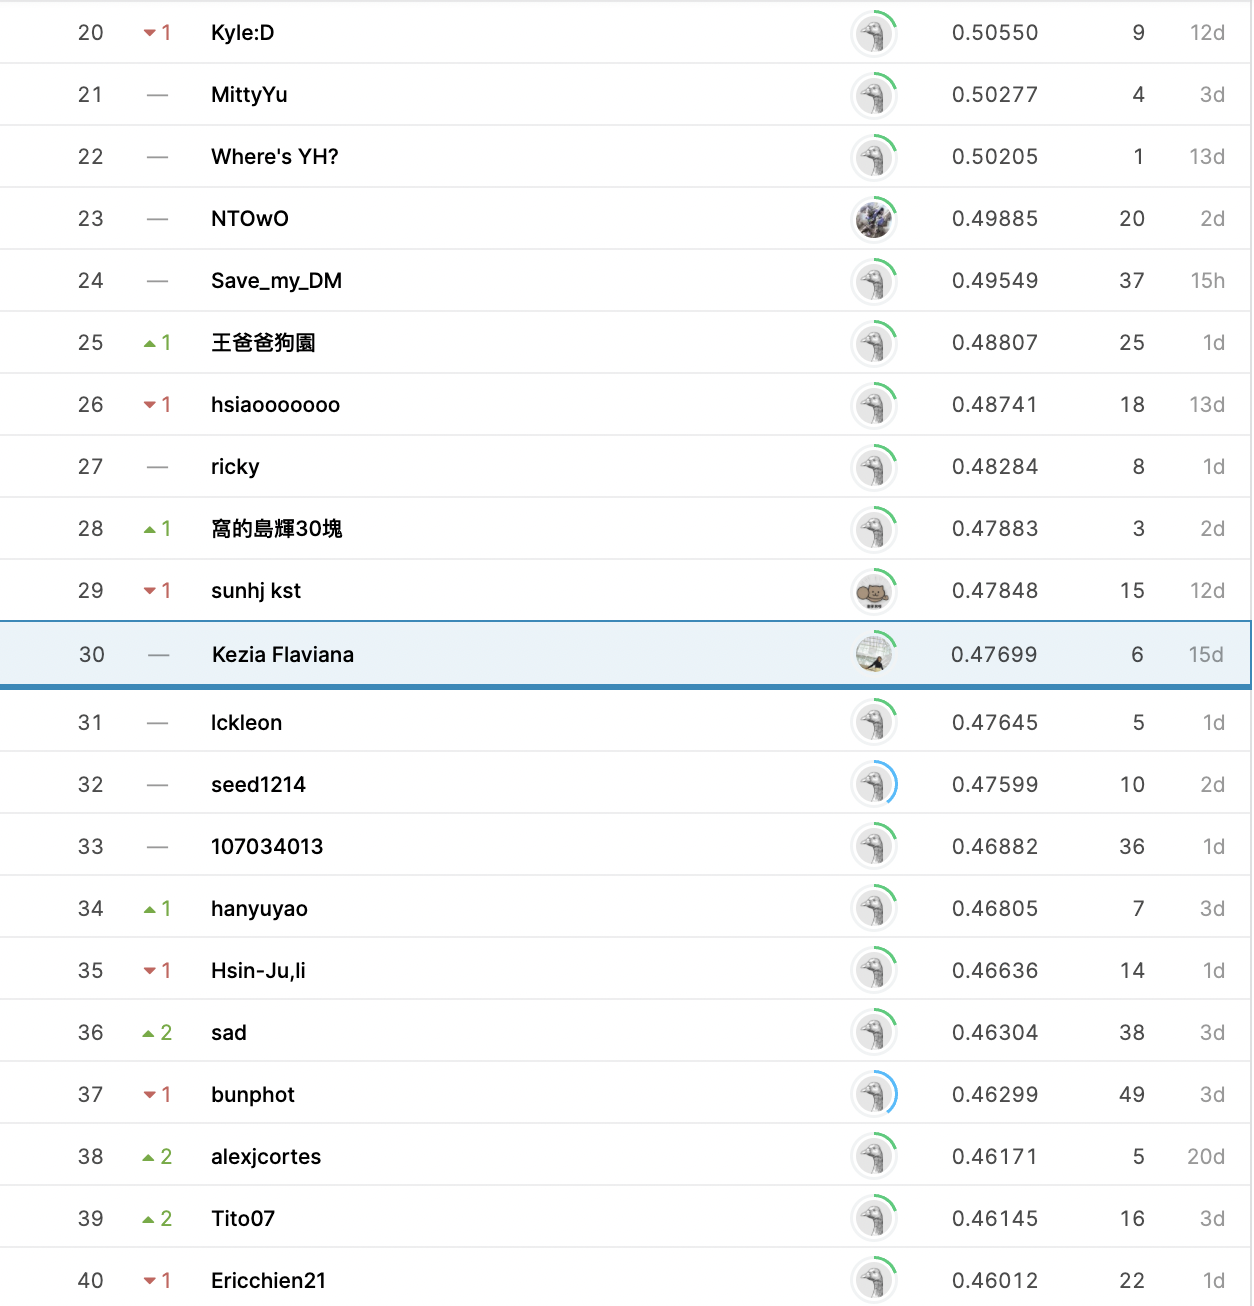

---

# Part 3
The Kaggle Competition report on sentiment analysis is thoroughly explained on another notebook.

Kaggle Notebook: https://www.kaggle.com/keziaflaviana/sentiment-analysis-glove-bilstm

Github: https://github.com/keziatamus/DM2021-Lab2-Homework/blob/main/sentiment-analysis-glove-bilstm.ipynb